# import library

In [1]:
# import all library
import datetime, time, os, sys, copy, glob
#import mir_eval, dill, librosa, IPython
import _pickle as pickle
import numpy as np
import pandas as pd
#from scipy.spatial.distance import euclidean, pdist, squareform
#import IPython.display as ipd
#from datetime import datetime
from time import gmtime, strftime
#from imageio import imread as imread
#from imageio import imsave as imsave
#import librosa.display
import tensorflow as tf
#from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
#from midiutil.MidiFile import MIDIFile
#import ray
from ops import *
#import pydub
#from ADTLib import ADT
import matplotlib.pyplot as plt
%matplotlib inline

# show version info
print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))
print ("[info] Python Version:   " + sys.version.split('\n')[0].split(' ')[0])
print ("[info] Working Dir:      " + os.getcwd()+'/')
print ("[info] Tensorflow:       " + tf.__version__)

# enable gpu usage constraint here
fixed_gpu_usage = 1
enabled_gpu_id = 2

# if gpu usage is constraint, limit certain gpu for use
if (fixed_gpu_usage == 1):
    # set available GPU
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"                       # list GPU sequence by PCI bus GPU ID
    #os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"                        # 
    os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(enabled_gpu_id)     # 0,1,2

    # check available GPU
    from tensorflow.python.client import device_lib
    for x in range(1, len(device_lib.list_local_devices())):
        print ("[info] GPU " + device_lib.list_local_devices()[x].physical_device_desc)

[info] Current Time:     2019/04/29  17:51:22
[info] Python Version:   3.6.5
[info] Working Dir:      /host/home/python/musegan_npz/sarr_vae_2950x/
[info] Tensorflow:       1.8.0
[info] GPU device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0c:00.0, compute capability: 7.5


# Training Section Start From Here

# reload SSM flist

In [2]:
# show reading function output data format
train_file_names = np.sort(glob.glob('../ssd_970_0/bar_level_pad_ssm/train/*.pkl', recursive=True)).tolist()

ag_ssm_train_flist = train_file_names
np.random.shuffle(ag_ssm_train_flist)
#ag_ssm_train_flist = train_file_names[:np.int(len(train_file_names)*0.05)]
print ('[info] Train SSM files: {}'.format(len(ag_ssm_train_flist)))

for x in ag_ssm_train_flist[:3]: print ("    " + x)
print ('')
    
test1_file_names = np.sort(glob.glob('../ssd_970_0/bar_level_pad_ssm/test/*.pkl', recursive=True)).tolist()
print ('[info] Test1 SSM files: {}'.format(len(test1_file_names)))

for x in test1_file_names[:3]: print ("    " + x)
print ('')

test2_file_names = np.sort(glob.glob('../ssd_970_0/bar_level_pad_ssm/test_midi/*.pkl', recursive=True)).tolist()
print ('[info] Test2 SSM files: {}'.format(len(test2_file_names)))

for x in test2_file_names[:3]: print ("    " + x)
print ('')

ag_ssm_test_flist = copy.deepcopy(test1_file_names)
ag_ssm_test_flist.extend(test2_file_names[:])
print ('[info] All Test SSM files: {}'.format(len(ag_ssm_test_flist)))

[info] Train SSM files: 8916
    ../ssd_970_0/bar_level_pad_ssm/train/bar_level_ssm_train_02640.pkl
    ../ssd_970_0/bar_level_pad_ssm/train/bar_level_ssm_train_07887.pkl
    ../ssd_970_0/bar_level_pad_ssm/train/bar_level_ssm_train_07328.pkl

[info] Test1 SSM files: 991
    ../ssd_970_0/bar_level_pad_ssm/test/bar_level_ssm_test_00014.pkl
    ../ssd_970_0/bar_level_pad_ssm/test/bar_level_ssm_test_00037.pkl
    ../ssd_970_0/bar_level_pad_ssm/test/bar_level_ssm_test_00039.pkl

[info] Test2 SSM files: 24
    ../ssd_970_0/bar_level_pad_ssm/test_midi/test_midi_song_00.pkl
    ../ssd_970_0/bar_level_pad_ssm/test_midi/test_midi_song_01.pkl
    ../ssd_970_0/bar_level_pad_ssm/test_midi/test_midi_song_02.pkl

[info] All Test SSM files: 1015


# Show package data format

In [3]:
# check train files
pkl_file_name_in = train_file_names[0]
with open(pkl_file_name_in, 'rb') as pkl_file:        
    reload_ssm_pkg1 = pickle.load(pkl_file)
    
print("[info] train pkg content:    {}".format(len(reload_ssm_pkg1)))
print("[info] CQT SSM reflect:      {}".format(reload_ssm_pkg1[0].shape))
print("[info] Drum SSM:             {}".format(reload_ssm_pkg1[1].shape))
print("[info] Drum SSM reflect:     {}".format(reload_ssm_pkg1[2].shape))
print("[info] Song len format:      {}\n".format(reload_ssm_pkg1[3]))

# check test1 files
pkl_file_name_in = test1_file_names[0]
with open(pkl_file_name_in, 'rb') as pkl_file:        
    reload_ssm_pkg2 = pickle.load(pkl_file)
    
print("[info] test1 pkg content:    {}".format(len(reload_ssm_pkg2)))
print("[info] CQT SSM reflect:      {}".format(reload_ssm_pkg2[0].shape))
print("[info] Drum SSM:             {}".format(reload_ssm_pkg2[1].shape))
print("[info] Drum SSM reflect:     {}".format(reload_ssm_pkg2[2].shape))
print("[info] Song len format:      {}\n".format(reload_ssm_pkg2[3]))

# check test2 files
pkl_file_name_in = test2_file_names[0]
with open(pkl_file_name_in, 'rb') as pkl_file:        
    reload_ssm_pkg3 = pickle.load(pkl_file)
    
print("[info] test2 pkg content:    {}".format(len(reload_ssm_pkg3)))
print("[info] CQT SSM reflect:      {}".format(reload_ssm_pkg3[0].shape))
print("[info] Drum SSM:             {}".format(reload_ssm_pkg3[1].shape))
print("[info] Drum SSM Mask:        {}".format(reload_ssm_pkg3[2].shape))
print("[info] Mask pix value mean:  {:.5f}".format(reload_ssm_pkg3[3]))
print("[info] Song len format:      {}".format(reload_ssm_pkg3[4]))

[info] train pkg content:    4
[info] CQT SSM reflect:      (256, 256, 3)
[info] Drum SSM:             (256, 256, 3)
[info] Drum SSM reflect:     (256, 256, 1)
[info] Song len format:      135

[info] test1 pkg content:    4
[info] CQT SSM reflect:      (256, 256, 3)
[info] Drum SSM:             (256, 256, 3)
[info] Drum SSM reflect:     (256, 256, 1)
[info] Song len format:      175

[info] test2 pkg content:    5
[info] CQT SSM reflect:      (256, 256, 3)
[info] Drum SSM:             (256, 256, 3)
[info] Drum SSM Mask:        (256, 256, 3)
[info] Mask pix value mean:  0.07860
[info] Song len format:      101


# plot data to see format

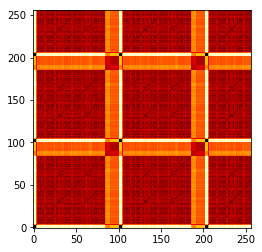

In [4]:
plot_data0 = reload_ssm_pkg3[0][:,:,0]
plt.figure(figsize=(4, 4))
plt.imshow(plot_data0, origin='lower', cmap='hot')
plt.show()

# Re-load all training SSM data here

In [5]:
# define reading function
def read_pkl_function(pkl_file_name_in):
    
    # convert data into correct type
    if type(pkl_file_name_in)!=str:
        pkl_file_name_in = pkl_file_name_in.decode("utf-8")   
    
    # load saved SSM data
    with open(pkl_file_name_in, 'rb') as pkl_file:        
        reload_ssm_pkg = pickle.load(pkl_file)
    
    # for train case
    if "bar_level_ssm_train" in pkl_file_name_in:
        cqt_ssm_data =            reload_ssm_pkg[0].astype(np.float32)
        drum_ssm_data =           reload_ssm_pkg[1].astype(np.float32)
        drum_ssm_data_rfv =       reload_ssm_pkg[2].astype(np.float32)
        song_bar_num =            np.array([reload_ssm_pkg[3]]).astype(np.int32)
        vae_recon_ls_ratio =      np.array([0.7]).astype(np.float32)
        vae_dis_ls_ratio =        np.array([0.3]).astype(np.float32)
        
    
    # for test case 1
    elif "bar_level_ssm_test" in pkl_file_name_in:
        cqt_ssm_data =            reload_ssm_pkg[0].astype(np.float32)
        drum_ssm_data =           np.zeros([256,256,3]).astype(np.float32)
        drum_ssm_data_rfv =       np.zeros([256,256,1]).astype(np.float32)
        song_bar_num =            np.array([reload_ssm_pkg[3]]).astype(np.int32)
        vae_recon_ls_ratio =      np.array([0.0]).astype(np.float32)
        vae_dis_ls_ratio =        np.array([1.0]).astype(np.float32)
        
    # for test case 2
    elif "test_midi_song" in pkl_file_name_in:
        cqt_ssm_data =            reload_ssm_pkg[0].astype(np.float32)
        drum_ssm_data =           np.zeros([256,256,3]).astype(np.float32)
        drum_ssm_data_rfv =       np.zeros([256,256,1]).astype(np.float32)
        song_bar_num =            np.array([reload_ssm_pkg[4]]).astype(np.int32)
        vae_recon_ls_ratio =      np.array([0.0]).astype(np.float32)
        vae_dis_ls_ratio =        np.array([1.0]).astype(np.float32)
    
    # no use case
    else:
        pass
        
    
    out_pkg = [cqt_ssm_data,
               drum_ssm_data,
               drum_ssm_data_rfv,
               song_bar_num,
               vae_recon_ls_ratio,
               vae_dis_ls_ratio]
    
    #return cqt_ssm_data, drum_ssm_data, drum_ssm_mask, valid_pix_mean, song_bar_num
    return out_pkg


# show reading function output data format
print('[info] Total files: {}'.format(len(ag_ssm_train_flist)))

cqt_ssm_data_shape =         read_pkl_function(ag_ssm_train_flist[0])[0].shape
drum_ssm_data_shape =        read_pkl_function(ag_ssm_train_flist[0])[1].shape
drum_ssm_rfv_data_shape =    read_pkl_function(ag_ssm_train_flist[0])[2].shape
song_bar_num_shape =         read_pkl_function(ag_ssm_train_flist[0])[3].shape
vae_recon_ls_ratio_shape =   read_pkl_function(ag_ssm_train_flist[0])[3].shape
vae_dis_ls_ratio_shape =     read_pkl_function(ag_ssm_train_flist[0])[3].shape

print('out[0] shape: {}'.format(cqt_ssm_data_shape))
print('out[1] shape: {}'.format(drum_ssm_data_shape))
print('out[2] shape: {}'.format(drum_ssm_rfv_data_shape))
print('out[3] shape: {}'.format(song_bar_num_shape))
print('out[4] shape: {}'.format(vae_recon_ls_ratio_shape))
print('out[5] shape: {}'.format(vae_dis_ls_ratio_shape))

[info] Total files: 8916
out[0] shape: (256, 256, 3)
out[1] shape: (256, 256, 3)
out[2] shape: (256, 256, 1)
out[3] shape: (1,)
out[4] shape: (1,)
out[5] shape: (1,)


# check data format

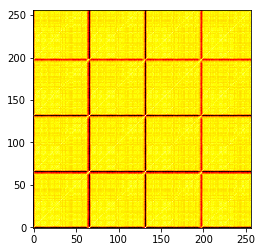

In [6]:
song_idx = 5
cqt_ssm_data =         read_pkl_function(ag_ssm_train_flist[song_idx])[0]
drum_ssm_data =        read_pkl_function(ag_ssm_train_flist[song_idx])[1]
drum_ssm_data_rfv =    read_pkl_function(ag_ssm_train_flist[song_idx])[2]
song_bar_num =         read_pkl_function(ag_ssm_train_flist[song_idx])[3]
vae_recon_ls_ratio =   read_pkl_function(ag_ssm_train_flist[song_idx])[4]
vae_dis_ls_ratio =     read_pkl_function(ag_ssm_train_flist[song_idx])[5]

# plot CQT data
plt.figure(figsize=(4, 4))
plt.imshow(-cqt_ssm_data[:,:,0], origin='lower', cmap='hot')
plt.show()

# set dataset.map function data shape

In [7]:
trf_out0_shape = read_pkl_function(ag_ssm_train_flist[0])[0].shape    # cqt ssm
trf_out1_shape = read_pkl_function(ag_ssm_train_flist[0])[1].shape    # drum ssm
trf_out2_shape = read_pkl_function(ag_ssm_train_flist[0])[2].shape    # drum rfv shape
trf_out3_shape = read_pkl_function(ag_ssm_train_flist[0])[3].shape    # song bar num
trf_out4_shape = read_pkl_function(ag_ssm_train_flist[0])[4].shape    # vae_recon_ls_ratio
trf_out5_shape = read_pkl_function(ag_ssm_train_flist[0])[5].shape    # vae_dis_ls_ratio

def tf_reshape_function(trf_out0, 
                        trf_out1, 
                        trf_out2, 
                        trf_out3,
                        trf_out4,
                        trf_out5):
    
    trf_out0.set_shape(trf_out0_shape)
    trf_out1.set_shape(trf_out1_shape)
    trf_out2.set_shape(trf_out2_shape)
    trf_out3.set_shape(trf_out3_shape)
    trf_out4.set_shape(trf_out4_shape)
    trf_out5.set_shape(trf_out5_shape)
    
    out_pkg = [trf_out0,
               trf_out1,
               trf_out2,
               trf_out3,
               trf_out4,
               trf_out5]

    #return trf_out0, trf_out1, trf_out2, trf_out3, trf_out4, trf_out
    return out_pkg

print('[info] \"dataset.map\" function is defined.')

[info] "dataset.map" function is defined.


# define TF dataset API

In [8]:
batch_size = 64 * 1

data_set_len = len(ag_ssm_train_flist)

ssm_dataset = tf.data.Dataset.from_tensor_slices(ag_ssm_train_flist)

ssm_dataset = ssm_dataset.shuffle(buffer_size=len(ag_ssm_train_flist), 
                                  reshuffle_each_iteration=True)

ssm_dataset = ssm_dataset.map(lambda train_file_name: tuple(tf.py_func(read_pkl_function,                    
                                                                       [train_file_name],
                                                                       [tf.float32, 
                                                                        tf.float32, 
                                                                        tf.float32,
                                                                        tf.int32,
                                                                        tf.float32,
                                                                        tf.float32,])),
                              num_parallel_calls=16)

ssm_dataset = ssm_dataset.map(tf_reshape_function, num_parallel_calls=16)

ssm_dataset = ssm_dataset.repeat(4)
ssm_dataset = ssm_dataset.shuffle(buffer_size=batch_size*16, reshuffle_each_iteration=True)
ssm_dataset = ssm_dataset.batch(batch_size=batch_size)
ssm_dataset = ssm_dataset.prefetch(buffer_size=batch_size*16)

batch_train_iter = ssm_dataset.make_initializable_iterator()

# get batch data
batch_cqt_ssm,                                         \
batch_drum_ssm,                                        \
batch_drum_ssm_rfv,                                    \
batch_song_len,                                        \
batch_vae_recon_ls_ratio,                              \
batch_vae_dis_ls_ratio = batch_train_iter.get_next()

print('[info] TF Data API is defined.')

[info] TF Data API is defined.


# Define Encoder Model

In [9]:
# define leaky relu function
def lrelu(x, alpha=0.05):
    return tf.maximum(x, tf.multiply(x, alpha))


# define spectrogram encoder
def ssm_encoder(sarr_cqt_ssm_input,        # (batch_num, 256, 256, 3)
                 reuse=False):
    
    n_latent = 32
    fmap_layer = 48
    
    with tf.variable_scope('ssm_nn_enc', reuse=reuse):
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
            
        else:
            assert tf.get_variable_scope().reuse is False
        
        # make padding Batch / Height / Width / Channel 
        sarr_cqt_ssm_input_pad = tf.pad(sarr_cqt_ssm_input, [[0, 0], [4, 4], [4, 4], [0, 0]], "CONSTANT")

        e0 = sarr_cqt_ssm_input_pad
            
        # image is (256 x 256 x input_c_dim)
        e1 = tf.nn.elu(instance_norm(conv2d(e0, fmap_layer*1, ks=[4,4], s=[2,2], name='g_e1_conv'), 'g_bn_e1'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = tf.nn.elu(instance_norm(conv2d(e1, fmap_layer*2, ks=[4,4], s=[2,2], name='g_e2_conv'), 'g_bn_e2'))
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = tf.nn.elu(instance_norm(conv2d(e2, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e3_conv'), 'g_bn_e3'))
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = tf.nn.elu(instance_norm(conv2d(e3, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e4_conv'), 'g_bn_e4'))
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = tf.nn.elu(instance_norm(conv2d(e4, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e5_conv'), 'g_bn_e5'))
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = tf.nn.elu(instance_norm(conv2d(e5, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e6_conv'), 'g_bn_e6'))
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = tf.nn.elu(instance_norm(conv2d(e6, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e7_conv'), 'g_bn_e7'))
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = tf.nn.elu(instance_norm(conv2d(e7, fmap_layer*4, ks=[4,4], s=[2,2], name='g_e8_conv'), 'g_bn_e8'))        
        
        conv_out = e8
        
        enc_convo_flat_out = tf.reshape(conv_out, [-1, np.prod(conv_out.get_shape()[1:])])
    
        
        enc_mlp_h1 = tf.layers.dense(inputs=enc_convo_flat_out,
                                     units=1024,
                                     activation=lrelu,
                                     name='enc_nn_mid_h1')
        
        enc_mlp_h2 = tf.layers.dense(inputs=enc_mlp_h1,
                                     units=1024,
                                     activation=lrelu,
                                     name='enc_nn_mid_h2')

        enc_mlp_h2m = lrelu(enc_mlp_h2 + enc_mlp_h1*0.2)
        
        enc_mlp_h3 = tf.layers.dense(inputs=enc_mlp_h2m,
                                     units=1024,
                                     activation=lrelu,
                                     name='enc_nn_mid_h3')
        
        enc_mlp_h3m = lrelu(enc_mlp_h3 + enc_mlp_h2m*0.2)      
        
        
        # define encoder output layer
        z_mean = tf.layers.dense(inputs=enc_mlp_h3m,
                                 units=n_latent,
                                 activation=None,
                                 name='enc_nn_z_mean')
            
        z_std = tf.layers.dense(inputs=enc_mlp_h3m, 
                                units=n_latent, 
                                activation=None,
                                name='enc_nn_z_std')
        
        z_epsilon = tf.random_normal(tf.stack([tf.shape(enc_mlp_h3m)[0], n_latent])) 
        
        z_latent  = z_mean + tf.multiply(z_epsilon, tf.exp(z_std * 0.5))
        
        return z_latent, z_mean, z_std
    
print ('Encoder define done.')

Encoder define done.


# Defining decoder model

In [10]:
# define leaky relu function
def lrelu(x, alpha=0.05):
    return tf.maximum(x, tf.multiply(x, alpha))

# define spectrogram encoder
def ssm_decoder(dec_z_sampled,         # (batch_num, 32)                 
                reuse=False):

    fmap_layer = 48
    output_c_dim = 1
    
    with tf.variable_scope('ssm_nn_dec', reuse=reuse):
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
            
        else:
            assert tf.get_variable_scope().reuse is False

                    
        # define z input layer
        dec_z_i_layer = tf.layers.dense(inputs=dec_z_sampled,
                                        units=256,
                                        activation=lrelu,
                                        name='dec_nn_zin')                
            
        dec_mlp_h1 = tf.layers.dense(inputs=dec_z_i_layer,
                                     units=1024,
                                     activation=lrelu,
                                     name='dec_nn_mid_h1')                                     
        
        dec_mlp_h2 = tf.layers.dense(inputs=dec_mlp_h1,
                                     units=1024,
                                     activation=lrelu,
                                     name='dec_nn_mid_h2')   
        
        dec_mlp_h2m = lrelu(dec_mlp_h2 + dec_mlp_h1*0.2)
        
        dec_mlp_h3 = tf.layers.dense(inputs=dec_mlp_h2m,
                                     units=2*2*fmap_layer*4,
                                     activation=lrelu,
                                     name='dec_nn_mid_h3')
        
        dec_mlp_h4 = tf.layers.dense(inputs=dec_mlp_h3,
                                     units=2*2*fmap_layer*4,
                                     activation=lrelu,
                                     name='dec_nn_mid_h4')
        
        dec_mlp_h4m = lrelu(dec_mlp_h4 + dec_mlp_h3*0.2)

        dec_dense_reshape_out = tf.reshape(dec_mlp_h4m, [-1, 2, 2, fmap_layer*4])
        
        
        # d2 is (2 x 2 x self.gf_dim*8*2)
        d1 = dec_dense_reshape_out
    
        d2 = tf.nn.elu(instance_norm(deconv2d(d1, fmap_layer*4, name='dec_nn_g_d2'), 'dec_nn_g_bn_d2'))
        #d2 = tf.nn.dropout(d2, keep_prob)
        #d2 = tf.concat([d2, e6*0.20], axis=3)
        # d2 is (4 x 4 x self.gf_dim*8*2)

        d3 = tf.nn.elu(instance_norm(deconv2d(d2, fmap_layer*4, name='dec_nn_g_d3'), 'dec_nn_g_bn_d3'))
        #d3 = tf.nn.dropout(d3, keep_prob)
        #d3 = tf.concat([d3, e5*0.20], axis=3)
        # d3 is (8 x 8 x self.gf_dim*8*2)

        d4 = tf.nn.elu(instance_norm(deconv2d(d3, fmap_layer*4, name='dec_nn_g_d4'), 'dec_nn_g_bn_d4'))
        #d4 = tf.concat([d4, e4*0.20], axis=3)
        # d4 is (16 x 16 x self.gf_dim*8*2)

        d5 = tf.nn.elu(instance_norm(deconv2d(d4, fmap_layer*4, name='dec_nn_g_d5'), 'dec_nn_g_bn_d5'))
        #d5 = tf.concat([d5, e3*0.10], axis=3)
        # d5 is (32 x 32 x self.gf_dim*4*2)

        d6 = tf.nn.elu(instance_norm(deconv2d(d5, fmap_layer*2, name='dec_nn_g_d6'), 'dec_nn_g_bn_d6'))
        #d6 = tf.concat([d6, e2*0.05], axis=3)
        # d6 is (64 x 64 x self.gf_dim*2*2)

        d7 = tf.nn.elu(instance_norm(deconv2d(d6, fmap_layer*2, name='dec_nn_g_d7'), 'dec_nn_g_bn_d7'))
        #d7 = tf.concat([d7, e1*0.025], axis=3)
        # d7 is (128 x 128 x self.gf_dim*1*2)

        #d8 = deconv2d(tf.nn.elu(d7), unet_output_c_dim, name='g_d8')
        d8 = deconv2d(d7, output_c_dim, name='dec_nn_g_d8')
        # d8 is (256 x 256 x output_c_dim)
        
        # finally get output
        #sarr_output = tf.nn.tanh(d8) * 200
        sarr_output = d8        

    
        return sarr_output

print ('Decoder define done.')

Decoder define done.


# Define Discriminator

In [11]:
def ssm_discriminator(sarr_drum_ssm_out,        # (batch_num, 256, 256, 3)
                      reuse=False):
    
    fmap_layer = 48
    
    with tf.variable_scope('ssm_nn_dis', reuse=reuse):
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
            
        else:
            assert tf.get_variable_scope().reuse is False

        
        sarr_drum_ssm_out_pad = tf.pad(sarr_drum_ssm_out, 
                                       [[0, 0], [4, 4], [4, 4], [0, 0]], 
                                       "CONSTANT")

        e0 = sarr_drum_ssm_out_pad
            
        # image is (256 x 256 x input_c_dim)
        e1 = tf.nn.elu(instance_norm(conv2d(e0, fmap_layer*1, ks=[4,4], s=[2,2], name='dis_nn_e1_conv'), 'dis_nn_bn_e1'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = tf.nn.elu(instance_norm(conv2d(e1, fmap_layer*2, ks=[4,4], s=[2,2], name='dis_nn_e2_conv'), 'dis_nn_bn_e2'))
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = tf.nn.elu(instance_norm(conv2d(e2, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e3_conv'), 'dis_nn_bn_e3'))
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = tf.nn.elu(instance_norm(conv2d(e3, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e4_conv'), 'dis_nn_bn_e4'))
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = tf.nn.elu(instance_norm(conv2d(e4, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e5_conv'), 'dis_nn_bn_e5'))
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = tf.nn.elu(instance_norm(conv2d(e5, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e6_conv'), 'dis_nn_bn_e6'))
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = tf.nn.elu(instance_norm(conv2d(e6, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e7_conv'), 'dis_nn_bn_e7'))
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = tf.nn.elu(instance_norm(conv2d(e7, fmap_layer*4, ks=[4,4], s=[2,2], name='dis_nn_e8_conv'), 'dis_nn_bn_e8'))        
        
        conv_out = e8
        
        dis_convo_flat_out = tf.reshape(conv_out, [-1, np.prod(conv_out.get_shape()[1:])])
    
        
        dis_mlp_h1 = tf.layers.dense(inputs=dis_convo_flat_out,
                                     units=1024,
                                     activation=lrelu,
                                     name='dis_nn_mid_h1')
        
        dis_mlp_h2 = tf.layers.dense(inputs=dis_mlp_h1,
                                     units=1024,
                                     activation=lrelu,
                                     name='dis_nn_mid_h2')

        dis_mlp_h2m = lrelu(dis_mlp_h2 + dis_mlp_h1*0.2)
        #dis_mlp_h2m = lrelu(instance_norm_fc(dis_mlp_h2 + dis_mlp_h1*0.2, name="dis_nn_instance_norm_1"))
        
        #dis_mlp_h3 = tf.layers.dense(inputs=dis_mlp_h2m,
        #                             units=1024,
        #                             activation=lrelu,
        #                             name='dis_nn_mid_h3')
        
        #dis_mlp_h3m = lrelu(instance_norm_fc(dis_mlp_h3 + dis_mlp_h2m*0.2, name="dis_nn_instance_norm_2"))
        
        # output layer process
        dis_logits = tf.layers.dense(dis_mlp_h2m, 
                                     units=128,
                                     activation=None,
                                     name='dis_nn_out_logit')
        
        dis_output = tf.sigmoid(dis_logits)
    
        return dis_output, dis_logits
    
print ('[info] Discriminator define done.')

[info] Discriminator define done.


# define function to calculate diff y layer (time-axis)

In [12]:
# note: input tensor must be 4-D data
def get_matx_2_layer_tf(matx_data_in):
    
    matx_layer_0 = matx_data_in
    
    matx_data_pady = tf.pad(matx_data_in,
                            paddings=[[0,0], [0,0], [1,0], [0,0]],
                            mode='CONSTANT',
                            name='tf_diff2_pady',
                            constant_values=0
                            )[:, :, :-1, :]
                            #)[:, :matx_data_in.get_shape()[1], :, :]
        
    matx_layer_1 = matx_data_in - matx_data_pady
    
    matx_layer_1_concat = tf.concat([tf.zeros_like(matx_layer_1)[:,:,0:1,:], 
                                     matx_layer_1[:,:,1:,:]],
                                    axis=2)
    
    
    matx_layer_all = tf.concat([matx_layer_0, matx_layer_1_concat], 
                               axis=-1,
                               name='tf_diff2_concat')
    
    return matx_layer_all    
    
print ('Diff-2 function define done.')

Diff-2 function define done.


# Define get 3 layer diff function

In [13]:
# note: input tensor must be 4-D data
def get_matx_3_layer_tf(matx_data_in):
    
    matx_layer_0 = matx_data_in
    
    matx_data_pady = tf.pad(matx_data_in,
                            paddings=[[0,0], [0,0], [1,0], [0,0]],
                            mode='CONSTANT',
                            name='tf_diff3_pady',
                            constant_values=0
                            )[:, :, :-1, :]
                            #)[:, :matx_data_in.get_shape()[1], :, :]
        
    matx_layer_1 = matx_data_in - matx_data_pady
    
    matx_layer_1_concat = tf.concat([tf.zeros_like(matx_layer_1)[:,:,0:1,:], 
                                     matx_layer_1[:,:,1:,:]],
                                    axis=2)
    
    matx_data_padx = tf.pad(matx_data_in,
                            paddings=[[0,0], [1,0], [0,0], [0,0]],
                            mode='CONSTANT',
                            name='tf_diff3_padx',
                            constant_values=0
                            )[:, :-1, :, :]
                            #)[:, :, :matx_data_in.get_shape()[2], :]    
    
    matx_layer_2 = matx_data_in - matx_data_padx
    
    matx_layer_2_concat = tf.concat([tf.zeros_like(matx_layer_1)[:,0:1,:,:], 
                                     matx_layer_1[:,1:,:,:]],
                                    axis=1)
    
    matx_layer_all = tf.concat([matx_layer_0, matx_layer_1_concat, matx_layer_2_concat], 
                               axis=-1,
                               name='tf_diff3_concat')
    
    return matx_layer_all    
    
print ('Diff-3 function define done.')

Diff-3 function define done.


# define tensorflow function to get noise

In [14]:
def tf_broadcast(tensor, shape):
    return tensor + tf.zeros(shape, dtype=tensor.dtype)


def apply_random_noise(cqt_ssm_tensor_in):
    
    add_noise_ratio = 0.15
    layer0_bias_noise_ratio = 0.50
    
    layer0_bias_raw = tf.random_normal(shape=tf.shape(cqt_ssm_tensor_in[:, 0:1, 0:1, 0:1]),
                                       mean=0.0,
                                       stddev=3.045423*add_noise_ratio*layer0_bias_noise_ratio,
                                       dtype=tf.float32)
    
    layer0_bias = tf_broadcast(layer0_bias_raw, tf.shape(cqt_ssm_tensor_in[:,:,:,0:1]))
    
    layer0_variation = tf.random_normal(shape=tf.shape(cqt_ssm_tensor_in[:,:,:,0:1]),
                                        mean=0.0,
                                        stddev=1.210196*add_noise_ratio,
                                        dtype=tf.float32)
    
    layer1_variation = tf.random_normal(shape=tf.shape(cqt_ssm_tensor_in[:,:,:,0:1]),
                                        mean=0.0,
                                        stddev=0.940488*add_noise_ratio,
                                        dtype=tf.float32) 
    
    layer2_variation = tf.random_normal(shape=tf.shape(cqt_ssm_tensor_in[:,:,:,0:1]),
                                        mean=0.0,
                                        stddev=0.940488*add_noise_ratio,
                                        dtype=tf.float32)     
    
    
    cqt_ssm_tensor_out_layer0 = cqt_ssm_tensor_in[:,:,:,0:1] + layer0_bias + layer0_variation
    
    cqt_ssm_tensor_out_layer1 = cqt_ssm_tensor_in[:,:,:,1:2] + layer1_variation
    
    cqt_ssm_tensor_out_layer2 = cqt_ssm_tensor_in[:,:,:,2:3] + layer2_variation
    
    cqt_ssm_tensor_out = tf.concat([cqt_ssm_tensor_out_layer0,
                                    cqt_ssm_tensor_out_layer1,
                                    cqt_ssm_tensor_out_layer2], axis=-1)
    
    
    return cqt_ssm_tensor_out    

print ('noise function define done.')

noise function define done.


# define gather function

In [15]:
def tf_broadcast(tensor, shape):
    return (tensor + tf.zeros(shape, dtype=tensor.dtype))

def get_idx_base(batch_size_v,
                 matx_size):
    
    mtx_len_np = np.array([matx_size]).astype(np.int32)
    
    np_init_idx = np.zeros([(matx_size**2)*batch_size_v, 1]).astype(np.int32)
    np_init_idx[:,0] = np.arange((matx_size**2)*batch_size_v)//((matx_size**2)*batch_size_v//batch_size_v)
    
    with tf.variable_scope("index_op_{}".format(str(time.time())[5:10]), reuse=tf.AUTO_REUSE):
        
        index_bat_2d_out = tf.get_variable("tfv_batch_pos", 
                                initializer=np_init_idx,
                                dtype="int32")
        
        
        np_init_idx_base = ((np.arange(0,mtx_len_np*mtx_len_np)//mtx_len_np)*mtx_len_np).astype(np.int32)
        index_base_v = tf.get_variable("tfv_index_base_{}".format(str(time.time())[5:10]),
                                       initializer=np_init_idx_base,
                                       dtype="int32")
        index_base_v_2d_out = tf.tile(tf.reshape(index_base_v, [1,-1]), [batch_size_v,1])
        
        
        np_init_idx_inc = np.tile(np.arange(0,mtx_len_np),mtx_len_np).astype(np.int32)
        index_inc_v = tf.get_variable("tfv_index_inc_{}".format(str(time.time())[5:10]),
                                       initializer=np_init_idx_inc,
                                       dtype="int32")
        index_inc_v_2d_out = tf.tile(tf.reshape(index_inc_v, [1,-1]), [batch_size_v,1])
        
        
        np_init_idx_sub = np.tile(np.arange(0,mtx_len_np).reshape(-1,1),[1,mtx_len_np[0]]).astype(np.int32).reshape([-1])
        index_sub_v = tf.get_variable("tfv_index_sub_{}".format(str(time.time())[5:10]),
                                       initializer=np_init_idx_sub,
                                       dtype="int32")
        index_sub_v_2d_out = tf.tile(tf.reshape(index_sub_v, [1,-1]), [batch_size_v,1])        
        
    return index_bat_2d_out, index_base_v_2d_out, index_inc_v_2d_out, index_sub_v_2d_out


def gather_data_song_len_ary(data_in3d,
                             song_len_2d_in,
                             param_batch_size,
                             param_mtx_len_int):
    
    index_bat_2d,                                      \
    index_base_v_2d,                                   \
    index_inc_v_2d,                                    \
    index_sub_v_2d = get_idx_base(param_batch_size,    \
                                  param_mtx_len_int)

    song_len_tfv_2d = tf_broadcast(tf.reshape(song_len_2d_in,[-1,1]), tf.shape(index_sub_v_2d))

    index_sub_2d = tf.div(index_sub_v_2d, song_len_tfv_2d) * song_len_tfv_2d * mtx_len_int

    index_pos_2d = index_base_v_2d + tf.mod(index_inc_v_2d, song_len_tfv_2d) - index_sub_2d
    index_pos_2d_flat = tf.reshape(index_pos_2d, [-1,1])

    index_ary_2d = tf.concat([index_bat_2d[:,0:1],     \
                              index_pos_2d_flat],      \
                             axis=1)


    # reshape data first
    #data_in3d_flat = tf.reshape(data_in3d, [data_in3d.get_shape().as_list()[0], -1])
    data_in3d_flat = tf.reshape(data_in3d, [param_batch_size, -1])
    
    # gather all values
    data_in3d_flat_gnd = tf.gather_nd(data_in3d_flat,
                                      index_ary_2d)

    # reshape to original matrix
    data_in3d_gnd_rb = tf.reshape(data_in3d_flat_gnd, 
                                 [param_batch_size, 
                                  param_mtx_len_int, 
                                  param_mtx_len_int])
    
    return data_in3d_gnd_rb

print ('[info] gather function defined.')

[info] gather function defined.


# define trangle extraction function

In [16]:
# accepts only 3-D tensor
def tf_get_tri_rfv_mtx(tgrrm_tensor_in):
    
    a_2d_triu1 = tf.matrix_band_part(tgrrm_tensor_in, 0, -1)
    a_2d_triu2 = tf.transpose(a_2d_triu1, [0,2,1])
    a_2d_diag = tf.matrix_band_part(tgrrm_tensor_in, 0, 0)
    a_2d_mix = a_2d_triu1 + a_2d_triu2 - a_2d_diag
    
    return(a_2d_mix)

print ('[info] triangle function defined.')

[info] triangle function defined.


# Connect Encoder / Decoder Model

In [17]:
batch_cqt_data_with_noise = apply_random_noise(get_matx_2_layer_tf(batch_cqt_ssm))

# connect Eecoder
enc_out_z,          \
enc_out_zmn,        \
enc_out_zsd = ssm_encoder(batch_cqt_data_with_noise,            \
                          #batch_bar_style_data,                 \
                          #batch_bar_progress,                   \
                          #processed_cqt_data_double_layer,      \
                          reuse=False)

# connect Decoder
sarr_output_data = ssm_decoder(#batch_bar_tempo_data,     \
                               #batch_bar_style_data,     \
                               #batch_bar_progress,       \
                               #enc_out_nnp,              \
                               enc_out_z,                \
                               reuse=False)

sarr_output_data_3d = sarr_output_data[:,:,:,0]

# for debug only
#sarr_output_data_3d = sarr_output_data[:,:,:,0] * 1e-6 + batch_drum_ssm[:,:,:,0]

sarr_output_data_3d_ext_trig = tf_get_tri_rfv_mtx(sarr_output_data_3d)

batch_size_in = 64
mtx_len_int = 256
sarr_output_data_gather = gather_data_song_len_ary(sarr_output_data_3d_ext_trig,
                                                   batch_song_len,
                                                   batch_size_in,
                                                   mtx_len_int)

sarr_output_data_gather_4d = tf.reshape(sarr_output_data_gather, 
                                        [batch_size_in,
                                         mtx_len_int,
                                         mtx_len_int,
                                         1])

sarr_output_3_layer = get_matx_3_layer_tf(sarr_output_data_gather_4d)


print ('[info] SSM Encoder / SSM Decoder model are connected.')

[info] SSM Encoder / SSM Decoder model are connected.


# Connect SSM Discriminator

In [18]:
batch_drum_ssm_3_layer = get_matx_3_layer_tf(batch_drum_ssm_rfv)

dis_output_real, dis_logits_real = ssm_discriminator(batch_drum_ssm_3_layer)

dis_output_fake, dis_logits_fake = ssm_discriminator(sarr_output_3_layer, 
                                                     reuse=True)

print ('[info] SSM Discriminator model connected.')

[info] SSM Discriminator model connected.


# Define Losses

In [19]:
# soft range error for SSM reconstruction
def ssm_recon_loss_func(logits_in, 
                        labels_in,
                        vae_recon_ls_ratio_in):
    
    tf_abs_error = tf.abs(logits_in - labels_in)
    
    # set soft range loss
    soft_loss_range = 1.0 * (1.0 / 100.0)
    tf_soft_abs_error = tf.where(tf_abs_error <= soft_loss_range * tf.ones_like(tf_abs_error),
                                 tf.zeros_like(tf_abs_error),
                                 tf_abs_error - soft_loss_range * tf.ones_like(tf_abs_error)
                                 )
    
    # keep only batch dimention
    tf_soft_abs_error_batch_1d = tf.reduce_mean(tf_soft_abs_error, (1,2,3))
    
    tf_soft_abs_error_ratio = tf.multiply(tf_soft_abs_error_batch_1d,
                                          vae_recon_ls_ratio_in)
    
    single_value_error = tf.reduce_mean(tf_soft_abs_error_ratio) * 100.0
    
    return single_value_error


# latent value z loss
def latent_z_lossf(z_value_mean, z_value_std):    
    return tf.reduce_sum(tf.square(z_value_mean) + tf.exp(z_value_std) - z_value_std, axis=1)


# discriminator loss func
def dis_loss_func(dis_logits_in, dis_labels_in):
    batch_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_in,
                                                                  labels=dis_labels_in)
    return tf.reduce_mean(batch_cross_entropy)


# discriminator loss func (ratio)
def dis_loss_func_ratio(dis_logits_in, dis_labels_in, vae_dis_ls_ratio_in):
    element_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_in,
                                                                    labels=dis_labels_in)
    # keep only batch dimention
    element_cross_entropy_1d = tf.reduce_mean(element_cross_entropy, 1)
    batch_cross_entropy_ratio = tf.multiply(element_cross_entropy_1d,
                                            vae_dis_ls_ratio_in)
    
    return tf.reduce_mean(batch_cross_entropy_ratio)


def dis_loss_func_mae(dis_logits_in, dis_labels_in):
    abs_diff = tf.abs(dis_labels_in - dis_logits_in)
    output = tf.reduce_mean( (abs_diff + tf.ones_like(abs_diff) )**0.25 )
    out_v = (output - tf.ones_like(output)) * 10.0
    return tf.reduce_mean(out_v)


def dis_loss_func_ratio_mae(dis_logits_in, dis_labels_in, vae_dis_ls_ratio_in):
    abs_diff = tf.abs(dis_labels_in - dis_logits_in)
    output_1d = tf.reduce_mean( (abs_diff + tf.ones_like(abs_diff) )**0.25, 1 )
    out_v_1d2 = (output_1d - tf.ones_like(output_1d)) * 10.0
    out_v_1d3 = tf.multiply(out_v_1d2, vae_dis_ls_ratio_in)
    return tf.reduce_mean(out_v_1d3)


# use soft range function to calculate SSM reconstruction loss
ssm_recon_loss = ssm_recon_loss_func(sarr_output_3_layer,
                                     batch_drum_ssm_3_layer,
                                     batch_vae_recon_ls_ratio)

vae_latent_loss = latent_z_lossf(enc_out_zmn, enc_out_zsd) * 1.0e-3


# calculate VAE fools discriminator's loos
vae_dis_loss = dis_loss_func_ratio_mae(dis_logits_fake,
                                   tf.ones_like(dis_logits_fake)*0.9,
                                   batch_vae_dis_ls_ratio) / (0.3*0.9 + 1.0*0.1)
#vae_dis_loss = dis_loss_func_ratio(dis_output_fake,
#                                   tf.ones_like(dis_output_fake)*0.9,
#                                   batch_vae_dis_ls_ratio)



# calculate discriminator loss
dis_real_loss = dis_loss_func_mae(dis_logits_real,
                              tf.ones_like(dis_logits_real)*0.9)
#dis_real_loss = dis_loss_func(dis_output_real,
#                              tf.ones_like(dis_output_real)*0.9)

dis_fake_loss = dis_loss_func_mae(dis_logits_fake,
                              tf.ones_like(dis_logits_fake)*0.1)
#dis_fake_loss = dis_loss_func(dis_output_fake,
#                              tf.ones_like(dis_output_fake)*0.1)

dis_loss_total = (dis_real_loss + dis_fake_loss) * 0.5


# get 3 different loss terms
vae_tot_loss_v = (ssm_recon_loss + vae_latent_loss*0.1)*20.0 + vae_dis_loss
#vae_dis_loss_v = vae_dis_loss
gan_dis_loss_v = dis_loss_total


print ('[info] TF loss function define done.')

[info] TF loss function define done.


# Define Optimizer

In [20]:
# Define learning rate
#learning_rate1 = 1e-4
learning_rate1 = 5e-5
#learning_rate1 = 2e-5
#learning_rate1 = 1e-5
#learning_rate1 = 5e-6
#learning_rate1 = 2e-6

learning_rate2 = 2e-5


# Define all trainable variable
t_vars = tf.trainable_variables()

# count model trainable variables
print('[info] Total model params: {}'.format(np.sum([np.prod(v.shape) for v in t_vars if 'ssm_nn_' in v.name]).value))
print('[info] Encoder params: {}'.format(np.sum([np.prod(v.shape) for v in t_vars if 'ssm_nn_enc' in v.name]).value))
print('[info] Decoder params: {}'.format(np.sum([np.prod(v.shape) for v in t_vars if 'ssm_nn_dec' in v.name]).value))
print('[info] Discriminator params: {}\n'.format(np.sum([np.prod(v.shape) for v in t_vars if 'ssm_nn_dis' in v.name]).value))

# get VAE vars
sarr_vae_vars =      [var for var in t_vars if 'ssm_nn_enc' in var.name]
sarr_vae_vars.extend([var for var in t_vars if 'ssm_nn_dec' in var.name])

# get Discriminator vars
sarr_dis_vars = [var for var in t_vars if 'ssm_nn_dis' in var.name]

# get all vars
sarr_tot_vars =      [var for var in t_vars if 'ssm_nn_enc' in var.name]
sarr_tot_vars.extend([var for var in t_vars if 'ssm_nn_dec' in var.name])
sarr_tot_vars.extend([var for var in t_vars if 'ssm_nn_dis' in var.name])

print('')
print([var.name for var in sarr_tot_vars])

sarr_vae_tot_trainer =  tf.train.AdamOptimizer(learning_rate1).minimize(vae_tot_loss_v,   var_list=sarr_vae_vars)
#sarr_gan_dis_trainer =  tf.train.AdamOptimizer(learning_rate2).minimize(gan_dis_loss_v,   var_list=sarr_dis_vars)

#sarr_vae_tot_trainer = tf.train.GradientDescentOptimizer(learning_rate1).minimize(vae_tot_loss_v, var_list=sarr_vae_vars)
#sarr_gan_dis_trainer = tf.train.GradientDescentOptimizer(learning_rate2).minimize(gan_dis_loss_v, var_list=sarr_dis_vars)

sarr_gan_dis_trainer = tf.train.AdadeltaOptimizer(learning_rate2*50).minimize(gan_dis_loss_v, var_list=sarr_dis_vars)
#sarr_trainer = tf.train.RMSPropOptimizer(learning_rate).minimize(sarr_loss, var_list=sarr_vars)

[info] Total model params: 17069952
[info] Encoder params: 6274912
[info] Decoder params: 5504128
[info] Discriminator params: 5290912


['ssm_nn_enc/g_e1_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e1/scale:0', 'ssm_nn_enc/g_bn_e1/offset:0', 'ssm_nn_enc/g_e2_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e2/scale:0', 'ssm_nn_enc/g_bn_e2/offset:0', 'ssm_nn_enc/g_e3_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e3/scale:0', 'ssm_nn_enc/g_bn_e3/offset:0', 'ssm_nn_enc/g_e4_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e4/scale:0', 'ssm_nn_enc/g_bn_e4/offset:0', 'ssm_nn_enc/g_e5_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e5/scale:0', 'ssm_nn_enc/g_bn_e5/offset:0', 'ssm_nn_enc/g_e6_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e6/scale:0', 'ssm_nn_enc/g_bn_e6/offset:0', 'ssm_nn_enc/g_e7_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e7/scale:0', 'ssm_nn_enc/g_bn_e7/offset:0', 'ssm_nn_enc/g_e8_conv/Conv/weights:0', 'ssm_nn_enc/g_bn_e8/scale:0', 'ssm_nn_enc/g_bn_e8/offset:0', 'ssm_nn_enc/enc_nn_mid_h1/kernel:0', 'ssm_nn_enc/enc_nn_mid_h1

# Run training loops here

In [21]:
print ("[info] Training job runing...")
print ('[info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')

chkpt_ver = 'v15_vae_gan5'

reload_model = True
#reload_model = False

# set traning time limit
time_limit = datetime.timedelta(days =      0,
                                hours =   240,
                                minutes =   0,
                                seconds =   0)


# traininig parameters setting
batch_size =       64
run_epoch_ratio =  1.0
show_info_epoch =  1
save_model_epoch = 10
epoch_target =     1000000
data_set_len =     data_set_len

# create DIR if not exist
directory = './sarr_models_{}'.format(chkpt_ver)
if not os.path.exists(directory):
    os.makedirs(directory)

# init tensorflow variables
init_tfv = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=sarr_tot_vars)
sarr_config = tf.ConfigProto(allow_soft_placement=True)
sarr_config.gpu_options.allow_growth = True

# run TF session here
with tf.Session(config=sarr_config) as sess:
    
    start_time = datetime.datetime.now()
    
    sess.run(init_tfv)
    
    # reload model
    if reload_model:
        saver.restore(sess, './sarr_models_{}/model_data.ckpt'.format(chkpt_ver))
        print ('[info] Model parameters are loaded.\n')
    
#    ep_vae_recon_loss1_list = []
#    ep_vae_laten_loss1_list = []
#    ep_vae_discr_loss1_list = []
#    ep_vae_total_loss1_list = []
    ep_vae_recon_loss3_list = []
    ep_vae_laten_loss3_list = []
    ep_vae_total_loss3_list = []
    ep_vae_discr_loss3_list = []
    ep_gan_discr_loss3_list = []
    

#    batch_vae_recon_loss1_list = []
#    batch_vae_laten_loss1_list = []
#    batch_vae_discr_loss1_list = []
#    batch_vae_total_loss1_list = []
    batch_vae_recon_loss3_list = []
    batch_vae_laten_loss3_list = []
    batch_vae_total_loss3_list = []
    batch_vae_discr_loss3_list = []
    batch_gan_discr_loss3_list = []
    
    
    epoch_runned = 0
    
    batch_num_in_epoch = int((data_set_len*run_epoch_ratio)//batch_size)
    
    print ('[info] Training loop start...')
    
    # run Epoch loop here
    for epoch_idx in range(0, epoch_target):
        
        sess.run(batch_train_iter.initializer)

#        batch_vae_recon_loss1_list = []
#        batch_vae_laten_loss1_list = []
#        batch_vae_discr_loss1_list = []
#        batch_vae_total_loss1_list = []
#        batch_vae_recon_loss3_list = []
#        batch_vae_laten_loss3_list = []
#        batch_vae_total_loss3_list = []
#        batch_vae_discr_loss3_list = []
#        batch_gan_discr_loss3_list = []

        ep_vae_trainner_runned = 0
        ep_dis_trainner_runned = 0
    
        # run batch loop here
        for batch_idx_raw in range(1, batch_num_in_epoch+1):
            
            batch_idx = (batch_idx_raw%30)+1
            
            # optimizer VAE recon + latent loss
            skip_train_vae = 0
            if (epoch_runned>=1):
                epoch_times_k0 = 139*1
                batch_vae_discr_loss_mean_v = np.mean(batch_vae_discr_loss3_list[-epoch_times_k0:])
                batch_gan_discr_loss_mean_v = np.mean(batch_gan_discr_loss3_list[-epoch_times_k0:])
                dis_gan_loss_ratio = batch_gan_discr_loss_mean_v/batch_vae_discr_loss_mean_v
                if dis_gan_loss_ratio> 2.2:
                    if (batch_idx%1==0):   skip_train_vae=1
                if dis_gan_loss_ratio> 2.1:
                    if (batch_idx%2==0):   skip_train_vae=1
                if dis_gan_loss_ratio> 2.0:
                    if (batch_idx%3==0):   skip_train_vae=1
                if dis_gan_loss_ratio> 1.9:
                    if (batch_idx%5==0):   skip_train_vae=1
                if dis_gan_loss_ratio> 1.7:
                    if (batch_idx%7==0):   skip_train_vae=1
                if dis_gan_loss_ratio> 1.6:
                    if (batch_idx%11==0):  skip_train_vae=1
                if dis_gan_loss_ratio> 1.5:
                    if (batch_idx%13==0):  skip_train_vae=1
                if dis_gan_loss_ratio> 1.4:
                    if (batch_idx%17==0):  skip_train_vae=1
                if dis_gan_loss_ratio> 1.3:
                    if (batch_idx%19==0):  skip_train_vae=1
                if dis_gan_loss_ratio> 1.2:
                    if (batch_idx%23==0):  skip_train_vae=1
                if dis_gan_loss_ratio> 1.1:
                    if (batch_idx%29==0):  skip_train_vae=1
                        
            if epoch_runned>=1 and skip_train_vae==0:
#                _tr1,                                                           \
#                batch_vae_recon_loss1,                                          \
#                batch_vae_laten_loss1,                                          \
#                batch_vae_discr_loss1,                                          \
#                batch_vae_total_loss1 = sess.run([sarr_vae_tot_trainer,         \
#                                                 ssm_recon_loss,                \
#                                                 vae_latent_loss,               \
#                                                 vae_dis_loss,                  \
#                                                 vae_tot_loss_v])
                _tr1 = sess.run([sarr_vae_tot_trainer])
                ep_vae_trainner_runned +=1
            
            
            # optimizer Discriminator loss
            skip_train_dis = 0
            if (epoch_runned>=1):
                epoch_times_k0 = 139*1
                batch_vae_discr_loss_mean_v = np.mean(batch_vae_discr_loss3_list[-epoch_times_k0:])
                batch_gan_discr_loss_mean_v = np.mean(batch_gan_discr_loss3_list[-epoch_times_k0:])
                gen_dis_loss_ratio = batch_vae_discr_loss_mean_v/batch_gan_discr_loss_mean_v
                if gen_dis_loss_ratio> 2.2:
                    if (batch_idx%1==0):   skip_train_dis=1
                if gen_dis_loss_ratio> 2.1:
                    if (batch_idx%2==0):   skip_train_dis=1
                if gen_dis_loss_ratio> 2.0:
                    if (batch_idx%3==0):   skip_train_dis=1
                if gen_dis_loss_ratio> 1.9:
                    if (batch_idx%5==0):   skip_train_dis=1
                if gen_dis_loss_ratio> 1.7:
                    if (batch_idx%7==0):   skip_train_dis=1
                if gen_dis_loss_ratio> 1.6:
                    if (batch_idx%11==0):  skip_train_dis=1
                if gen_dis_loss_ratio> 1.5:
                    if (batch_idx%13==0):  skip_train_dis=1
                if gen_dis_loss_ratio> 1.4:
                    if (batch_idx%17==0):  skip_train_dis=1
                if gen_dis_loss_ratio> 1.3:
                    if (batch_idx%19==0):  skip_train_dis=1
                if gen_dis_loss_ratio> 1.2:
                    if (batch_idx%23==0):  skip_train_dis=1
                if gen_dis_loss_ratio> 1.1:
                    if (batch_idx%29==0):  skip_train_dis=1
                        
            if epoch_runned>=1 and skip_train_dis==0:
#                _tr3,                                                           \
#                batch_vae_recon_loss3,                                          \
#                batch_vae_laten_loss3,                                          \
#                batch_vae_total_loss3,                                          \
#                batch_vae_discr_loss3,                                          \
#                batch_gan_discr_loss3 = sess.run([sarr_gan_dis_trainer,         \
#                                                 ssm_recon_loss,                \
#                                                 vae_latent_loss,               \
#                                                 vae_tot_loss_v,                \
#                                                 vae_dis_loss,                  \
#                                                 gan_dis_loss_v])
                _tr3 = sess.run([sarr_gan_dis_trainer])
                ep_dis_trainner_runned += 1
    
    
    
            # get training data anyway
            batch_vae_recon_loss3,                                          \
            batch_vae_laten_loss3,                                          \
            batch_vae_total_loss3,                                          \
            batch_vae_discr_loss3,                                          \
            batch_gan_discr_loss3 = sess.run([ssm_recon_loss,               \
                                              vae_latent_loss,              \
                                              vae_tot_loss_v,               \
                                              vae_dis_loss,                 \
                                              gan_dis_loss_v])
            
            

            # record every batch loss value
            #batch_vae_recon_loss1_list.append(batch_vae_recon_loss1)
            #batch_vae_laten_loss1_list.append(batch_vae_laten_loss1)
            #batch_vae_discr_loss1_list.append(batch_vae_discr_loss1)
            #batch_vae_total_loss1_list.append(batch_vae_total_loss1)
            batch_vae_recon_loss3_list.append(batch_vae_recon_loss3)
            batch_vae_laten_loss3_list.append(batch_vae_laten_loss3)
            batch_vae_total_loss3_list.append(batch_vae_total_loss3)
            batch_vae_discr_loss3_list.append(batch_vae_discr_loss3)
            batch_gan_discr_loss3_list.append(batch_gan_discr_loss3)
            
            # keep last 3 epoch data
            epoch_times_k1 = 3
            #batch_vae_recon_loss1_list = batch_vae_recon_loss1_list[-139*epoch_times_k1:]
            #batch_vae_laten_loss1_list = batch_vae_laten_loss1_list[-139*epoch_times_k1:]
            #batch_vae_discr_loss1_list = batch_vae_discr_loss1_list[-139*epoch_times_k1:]
            #batch_vae_total_loss1_list = batch_vae_total_loss1_list[-139*epoch_times_k1:]
            batch_vae_recon_loss3_list = batch_vae_recon_loss3_list[-139*epoch_times_k1:]
            batch_vae_laten_loss3_list = batch_vae_laten_loss3_list[-139*epoch_times_k1:]
            batch_vae_total_loss3_list = batch_vae_total_loss3_list[-139*epoch_times_k1:]
            batch_vae_discr_loss3_list = batch_vae_discr_loss3_list[-139*epoch_times_k1:]
            batch_gan_discr_loss3_list = batch_gan_discr_loss3_list[-139*epoch_times_k1:]
            
            
        # record runned epoch
        epoch_runned += 1    
        
        # record time
        delta_time = datetime.datetime.now() - start_time          
        
        # get avg loss in one epoch
        epoch_times_k2 = 1
        #ep_vae_recon_loss1_list.append(np.mean(batch_vae_recon_loss1_list[-139*epoch_times_k2:]))
        #ep_vae_laten_loss1_list.append(np.mean(batch_vae_laten_loss1_list[-139*epoch_times_k2:]))
        #ep_vae_discr_loss1_list.append(np.mean(batch_vae_discr_loss1_list[-139*epoch_times_k2:]))
        #ep_vae_total_loss1_list.append(np.mean(batch_vae_total_loss1_list[-139*epoch_times_k2:]))
        ep_vae_recon_loss3_list.append(np.mean(batch_vae_recon_loss3_list[-139*epoch_times_k2:]))
        ep_vae_laten_loss3_list.append(np.mean(batch_vae_laten_loss3_list[-139*epoch_times_k2:]))
        ep_vae_total_loss3_list.append(np.mean(batch_vae_total_loss3_list[-139*epoch_times_k2:]))
        ep_vae_discr_loss3_list.append(np.mean(batch_vae_discr_loss3_list[-139*epoch_times_k2:]))
        ep_gan_discr_loss3_list.append(np.mean(batch_gan_discr_loss3_list[-139*epoch_times_k2:]))
        
        # cut list length if too long
        ep_list_max_len = 139
        
        #if len(ep_vae_recon_loss3_list) > ep_list_max_len:
            
            #ep_vae_recon_loss1_list = ep_vae_recon_loss1_list[-ep_max_list_len:]
            #ep_vae_laten_loss1_list = ep_vae_laten_loss1_list[-ep_max_list_len:]
            #ep_vae_discr_loss1_list = ep_vae_discr_loss1_list[-ep_max_list_len:]
            #ep_vae_total_loss1_list = ep_vae_total_loss1_list[-ep_max_list_len:]
        ep_vae_recon_loss3_list = ep_vae_recon_loss3_list[-ep_list_max_len:]
        ep_vae_laten_loss3_list = ep_vae_laten_loss3_list[-ep_list_max_len:]
        ep_vae_total_loss3_list = ep_vae_total_loss3_list[-ep_list_max_len:]
        ep_vae_discr_loss3_list = ep_vae_discr_loss3_list[-ep_list_max_len:]
        ep_gan_discr_loss3_list = ep_gan_discr_loss3_list[-ep_list_max_len:]
            
        
        # show training info
        if (epoch_runned%show_info_epoch)==0:
            
            #out_msg = "[info] Epoch [ {} / {} ]".format(epoch_runned, epoch_target)
            out_msg = "[info] Runned Epoch: {:4d}".format(epoch_runned)
            out_msg += ", "
            out_msg += "Elapse Time: {}".format(str(delta_time)[:-7])
            out_msg += ", "
            out_msg += "VAE rc: {:2.3f}".format(ep_vae_recon_loss3_list[-1])
            out_msg += ", "
            out_msg += "VAE ds: {:2.3f}".format(ep_vae_discr_loss3_list[-1])
            out_msg += ", "
            out_msg += "GAN ds: {:2.3f}".format(ep_gan_discr_loss3_list[-1])
            out_msg += ", "
            out_msg += "VAE/GAN: {:3d} / {:3d}".format(ep_vae_trainner_runned, ep_dis_trainner_runned)
            
            print (out_msg)
            
        # save model parameters during training
        if (epoch_runned%save_model_epoch)==0:
            
            saver.save(sess, './sarr_models_{}/model_data.ckpt'.format(chkpt_ver))
            print ('[info] Model parameter is saved.')
            print ('[info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            #print ("")
        
        # break training loop if training session expired
        if (delta_time >= time_limit):
            
            print ('[info] Elapse Time : {}'.format(str(delta_time)[:-7]))
            print ('[info] Time\'s up ! , Stop loop now.\n')
            break
        
    # save model after training
    saver.save(sess, './sarr_models_{}/model_data.ckpt'.format(chkpt_ver))
    print ('[info] Model parameter is saved.\n')

# show process is end
print ("[info] Traning is finished.")
print ("[info] " + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

[info] Training job runing...
[info] 2019-04-29 17:51:37

INFO:tensorflow:Restoring parameters from ./sarr_models_v15_vae_gan5/model_data.ckpt
[info] Model parameters are loaded.

[info] Training loop start...
[info] Runned Epoch:    1, Elapse Time: 0:00:32, VAE rc: 1.089, VAE ds: 0.741, GAN ds: 0.385, VAE/GAN:   0 /   0
[info] Runned Epoch:    2, Elapse Time: 0:02:11, VAE rc: 1.108, VAE ds: 0.739, GAN ds: 0.385, VAE/GAN: 139 /  57
[info] Runned Epoch:    3, Elapse Time: 0:03:51, VAE rc: 1.089, VAE ds: 0.730, GAN ds: 0.390, VAE/GAN: 139 /  72
[info] Runned Epoch:    4, Elapse Time: 0:05:31, VAE rc: 1.091, VAE ds: 0.743, GAN ds: 0.385, VAE/GAN: 139 /  76
[info] Runned Epoch:    5, Elapse Time: 0:07:07, VAE rc: 1.101, VAE ds: 0.741, GAN ds: 0.386, VAE/GAN: 139 /  61
[info] Runned Epoch:    6, Elapse Time: 0:08:42, VAE rc: 1.101, VAE ds: 0.741, GAN ds: 0.384, VAE/GAN: 139 /  58
[info] Runned Epoch:    7, Elapse Time: 0:10:17, VAE rc: 1.090, VAE ds: 0.735, GAN ds: 0.389, VAE/GAN: 139 /  59

[info] Runned Epoch:   69, Elapse Time: 1:48:49, VAE rc: 1.094, VAE ds: 0.749, GAN ds: 0.380, VAE/GAN: 139 /  57
[info] Runned Epoch:   70, Elapse Time: 1:50:24, VAE rc: 1.081, VAE ds: 0.742, GAN ds: 0.383, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-29 19:42:03
[info] Runned Epoch:   71, Elapse Time: 1:51:58, VAE rc: 1.105, VAE ds: 0.754, GAN ds: 0.375, VAE/GAN: 139 /  52
[info] Runned Epoch:   72, Elapse Time: 1:53:27, VAE rc: 1.115, VAE ds: 0.754, GAN ds: 0.376, VAE/GAN: 139 /  35
[info] Runned Epoch:   73, Elapse Time: 1:55:00, VAE rc: 1.086, VAE ds: 0.738, GAN ds: 0.385, VAE/GAN: 139 /  49
[info] Runned Epoch:   74, Elapse Time: 1:56:38, VAE rc: 1.090, VAE ds: 0.741, GAN ds: 0.385, VAE/GAN: 139 /  69
[info] Runned Epoch:   75, Elapse Time: 1:58:15, VAE rc: 1.067, VAE ds: 0.730, GAN ds: 0.391, VAE/GAN: 139 /  65
[info] Runned Epoch:   76, Elapse Time: 1:59:57, VAE rc: 1.079, VAE ds: 0.740, GAN ds: 0.386, VAE/GAN: 139 /  81
[info] Runned Epoch:   77, Elapse Ti

[info] Runned Epoch:  138, Elapse Time: 3:38:27, VAE rc: 1.095, VAE ds: 0.743, GAN ds: 0.383, VAE/GAN: 139 /  58
[info] Runned Epoch:  139, Elapse Time: 3:40:02, VAE rc: 1.077, VAE ds: 0.743, GAN ds: 0.383, VAE/GAN: 139 /  57
[info] Runned Epoch:  140, Elapse Time: 3:41:37, VAE rc: 1.082, VAE ds: 0.741, GAN ds: 0.381, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-29 21:33:16
[info] Runned Epoch:  141, Elapse Time: 3:43:13, VAE rc: 1.078, VAE ds: 0.745, GAN ds: 0.381, VAE/GAN: 139 /  57
[info] Runned Epoch:  142, Elapse Time: 3:44:48, VAE rc: 1.074, VAE ds: 0.746, GAN ds: 0.381, VAE/GAN: 139 /  57
[info] Runned Epoch:  143, Elapse Time: 3:46:20, VAE rc: 1.136, VAE ds: 0.756, GAN ds: 0.374, VAE/GAN: 139 /  47
[info] Runned Epoch:  144, Elapse Time: 3:47:45, VAE rc: 1.161, VAE ds: 0.759, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch:  145, Elapse Time: 3:49:11, VAE rc: 1.123, VAE ds: 0.759, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch:  146, Elapse Ti

[info] Runned Epoch:  207, Elapse Time: 5:26:48, VAE rc: 1.075, VAE ds: 0.749, GAN ds: 0.380, VAE/GAN: 139 /  41
[info] Runned Epoch:  208, Elapse Time: 5:28:24, VAE rc: 1.081, VAE ds: 0.741, GAN ds: 0.386, VAE/GAN: 139 /  57
[info] Runned Epoch:  209, Elapse Time: 5:29:58, VAE rc: 1.093, VAE ds: 0.750, GAN ds: 0.376, VAE/GAN: 139 /  56
[info] Runned Epoch:  210, Elapse Time: 5:31:33, VAE rc: 1.070, VAE ds: 0.739, GAN ds: 0.384, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-29 23:23:12
[info] Runned Epoch:  211, Elapse Time: 5:33:10, VAE rc: 1.070, VAE ds: 0.746, GAN ds: 0.382, VAE/GAN: 139 /  61
[info] Runned Epoch:  212, Elapse Time: 5:34:45, VAE rc: 1.069, VAE ds: 0.735, GAN ds: 0.387, VAE/GAN: 139 /  58
[info] Runned Epoch:  213, Elapse Time: 5:36:22, VAE rc: 1.094, VAE ds: 0.746, GAN ds: 0.381, VAE/GAN: 139 /  64
[info] Runned Epoch:  214, Elapse Time: 5:37:51, VAE rc: 1.132, VAE ds: 0.761, GAN ds: 0.371, VAE/GAN: 139 /  38
[info] Runned Epoch:  215, Elapse Ti

[info] Runned Epoch:  276, Elapse Time: 7:15:00, VAE rc: 1.095, VAE ds: 0.754, GAN ds: 0.378, VAE/GAN: 139 /  56
[info] Runned Epoch:  277, Elapse Time: 7:16:35, VAE rc: 1.084, VAE ds: 0.749, GAN ds: 0.379, VAE/GAN: 139 /  55
[info] Runned Epoch:  278, Elapse Time: 7:18:06, VAE rc: 1.122, VAE ds: 0.757, GAN ds: 0.375, VAE/GAN: 139 /  42
[info] Runned Epoch:  279, Elapse Time: 7:19:36, VAE rc: 1.089, VAE ds: 0.751, GAN ds: 0.377, VAE/GAN: 139 /  40
[info] Runned Epoch:  280, Elapse Time: 7:21:10, VAE rc: 1.082, VAE ds: 0.752, GAN ds: 0.378, VAE/GAN: 139 /  54
[info] Model parameter is saved.
[info] 2019-04-30 01:12:49
[info] Runned Epoch:  281, Elapse Time: 7:22:39, VAE rc: 1.089, VAE ds: 0.751, GAN ds: 0.376, VAE/GAN: 139 /  34
[info] Runned Epoch:  282, Elapse Time: 7:24:15, VAE rc: 1.068, VAE ds: 0.738, GAN ds: 0.387, VAE/GAN: 139 /  57
[info] Runned Epoch:  283, Elapse Time: 7:25:50, VAE rc: 1.061, VAE ds: 0.743, GAN ds: 0.384, VAE/GAN: 139 /  57
[info] Runned Epoch:  284, Elapse Ti

[info] Runned Epoch:  345, Elapse Time: 9:02:27, VAE rc: 1.070, VAE ds: 0.745, GAN ds: 0.383, VAE/GAN: 139 /  57
[info] Runned Epoch:  346, Elapse Time: 9:04:02, VAE rc: 1.066, VAE ds: 0.743, GAN ds: 0.383, VAE/GAN: 139 /  57
[info] Runned Epoch:  347, Elapse Time: 9:05:37, VAE rc: 1.065, VAE ds: 0.746, GAN ds: 0.382, VAE/GAN: 139 /  57
[info] Runned Epoch:  348, Elapse Time: 9:07:12, VAE rc: 1.072, VAE ds: 0.747, GAN ds: 0.378, VAE/GAN: 139 /  57
[info] Runned Epoch:  349, Elapse Time: 9:08:45, VAE rc: 1.061, VAE ds: 0.746, GAN ds: 0.382, VAE/GAN: 139 /  53
[info] Runned Epoch:  350, Elapse Time: 9:10:21, VAE rc: 1.072, VAE ds: 0.744, GAN ds: 0.383, VAE/GAN: 139 /  59
[info] Model parameter is saved.
[info] 2019-04-30 03:01:59
[info] Runned Epoch:  351, Elapse Time: 9:11:49, VAE rc: 1.096, VAE ds: 0.760, GAN ds: 0.373, VAE/GAN: 139 /  32
[info] Runned Epoch:  352, Elapse Time: 9:13:14, VAE rc: 1.087, VAE ds: 0.755, GAN ds: 0.378, VAE/GAN: 139 /  24
[info] Runned Epoch:  353, Elapse Ti

[info] Runned Epoch:  414, Elapse Time: 10:49:10, VAE rc: 1.064, VAE ds: 0.733, GAN ds: 0.388, VAE/GAN: 139 /  60
[info] Runned Epoch:  415, Elapse Time: 10:50:46, VAE rc: 1.068, VAE ds: 0.745, GAN ds: 0.382, VAE/GAN: 139 /  59
[info] Runned Epoch:  416, Elapse Time: 10:52:18, VAE rc: 1.092, VAE ds: 0.760, GAN ds: 0.372, VAE/GAN: 139 /  47
[info] Runned Epoch:  417, Elapse Time: 10:53:46, VAE rc: 1.074, VAE ds: 0.743, GAN ds: 0.382, VAE/GAN: 139 /  34
[info] Runned Epoch:  418, Elapse Time: 10:55:22, VAE rc: 1.076, VAE ds: 0.747, GAN ds: 0.380, VAE/GAN: 139 /  57
[info] Runned Epoch:  419, Elapse Time: 10:56:55, VAE rc: 1.064, VAE ds: 0.744, GAN ds: 0.380, VAE/GAN: 139 /  52
[info] Runned Epoch:  420, Elapse Time: 10:58:30, VAE rc: 1.073, VAE ds: 0.747, GAN ds: 0.382, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-30 04:50:09
[info] Runned Epoch:  421, Elapse Time: 11:00:05, VAE rc: 1.094, VAE ds: 0.748, GAN ds: 0.379, VAE/GAN: 139 /  53
[info] Runned Epoch:  422, E

[info] Runned Epoch:  483, Elapse Time: 12:36:36, VAE rc: 1.084, VAE ds: 0.745, GAN ds: 0.379, VAE/GAN: 139 /  49
[info] Runned Epoch:  484, Elapse Time: 12:38:05, VAE rc: 1.101, VAE ds: 0.756, GAN ds: 0.375, VAE/GAN: 139 /  38
[info] Runned Epoch:  485, Elapse Time: 12:39:31, VAE rc: 1.130, VAE ds: 0.761, GAN ds: 0.370, VAE/GAN: 139 /  25
[info] Runned Epoch:  486, Elapse Time: 12:40:56, VAE rc: 1.117, VAE ds: 0.761, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch:  487, Elapse Time: 12:42:22, VAE rc: 1.095, VAE ds: 0.756, GAN ds: 0.377, VAE/GAN: 139 /  24
[info] Runned Epoch:  488, Elapse Time: 12:43:55, VAE rc: 1.074, VAE ds: 0.748, GAN ds: 0.381, VAE/GAN: 139 /  51
[info] Runned Epoch:  489, Elapse Time: 12:45:30, VAE rc: 1.065, VAE ds: 0.750, GAN ds: 0.378, VAE/GAN: 139 /  57
[info] Runned Epoch:  490, Elapse Time: 12:47:04, VAE rc: 1.050, VAE ds: 0.743, GAN ds: 0.382, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-30 06:38:43
[info] Runned Epoch:  491, E

[info] Runned Epoch:  552, Elapse Time: 14:24:26, VAE rc: 1.049, VAE ds: 0.742, GAN ds: 0.384, VAE/GAN: 139 /  45
[info] Runned Epoch:  553, Elapse Time: 14:26:01, VAE rc: 1.057, VAE ds: 0.741, GAN ds: 0.383, VAE/GAN: 139 /  57
[info] Runned Epoch:  554, Elapse Time: 14:27:36, VAE rc: 1.057, VAE ds: 0.746, GAN ds: 0.384, VAE/GAN: 139 /  57
[info] Runned Epoch:  555, Elapse Time: 14:29:11, VAE rc: 1.051, VAE ds: 0.742, GAN ds: 0.382, VAE/GAN: 139 /  59
[info] Runned Epoch:  556, Elapse Time: 14:30:45, VAE rc: 1.075, VAE ds: 0.752, GAN ds: 0.376, VAE/GAN: 139 /  53
[info] Runned Epoch:  557, Elapse Time: 14:32:15, VAE rc: 1.070, VAE ds: 0.749, GAN ds: 0.380, VAE/GAN: 139 /  38
[info] Runned Epoch:  558, Elapse Time: 14:33:44, VAE rc: 1.086, VAE ds: 0.759, GAN ds: 0.374, VAE/GAN: 139 /  38
[info] Runned Epoch:  559, Elapse Time: 14:35:14, VAE rc: 1.076, VAE ds: 0.745, GAN ds: 0.379, VAE/GAN: 139 /  40
[info] Runned Epoch:  560, Elapse Time: 14:36:49, VAE rc: 1.075, VAE ds: 0.751, GAN ds: 

[info] Model parameter is saved.
[info] 2019-04-30 10:01:30
[info] Runned Epoch:  621, Elapse Time: 16:11:27, VAE rc: 1.057, VAE ds: 0.738, GAN ds: 0.384, VAE/GAN: 139 /  57
[info] Runned Epoch:  622, Elapse Time: 16:13:01, VAE rc: 1.073, VAE ds: 0.757, GAN ds: 0.376, VAE/GAN: 139 /  55
[info] Runned Epoch:  623, Elapse Time: 16:14:35, VAE rc: 1.055, VAE ds: 0.748, GAN ds: 0.383, VAE/GAN: 139 /  54
[info] Runned Epoch:  624, Elapse Time: 16:16:10, VAE rc: 1.060, VAE ds: 0.745, GAN ds: 0.382, VAE/GAN: 139 /  57
[info] Runned Epoch:  625, Elapse Time: 16:17:41, VAE rc: 1.077, VAE ds: 0.755, GAN ds: 0.376, VAE/GAN: 139 /  45
[info] Runned Epoch:  626, Elapse Time: 16:19:10, VAE rc: 1.068, VAE ds: 0.749, GAN ds: 0.377, VAE/GAN: 139 /  37
[info] Runned Epoch:  627, Elapse Time: 16:20:45, VAE rc: 1.066, VAE ds: 0.751, GAN ds: 0.378, VAE/GAN: 139 /  57
[info] Runned Epoch:  628, Elapse Time: 16:22:20, VAE rc: 1.055, VAE ds: 0.741, GAN ds: 0.384, VAE/GAN: 139 /  57
[info] Runned Epoch:  629, E

[info] Runned Epoch:  690, Elapse Time: 17:57:06, VAE rc: 1.076, VAE ds: 0.751, GAN ds: 0.377, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-04-30 11:48:45
[info] Runned Epoch:  691, Elapse Time: 17:58:41, VAE rc: 1.047, VAE ds: 0.744, GAN ds: 0.383, VAE/GAN: 139 /  53
[info] Runned Epoch:  692, Elapse Time: 18:00:16, VAE rc: 1.073, VAE ds: 0.749, GAN ds: 0.378, VAE/GAN: 139 /  57
[info] Runned Epoch:  693, Elapse Time: 18:01:50, VAE rc: 1.066, VAE ds: 0.746, GAN ds: 0.382, VAE/GAN: 139 /  54
[info] Runned Epoch:  694, Elapse Time: 18:03:24, VAE rc: 1.069, VAE ds: 0.744, GAN ds: 0.382, VAE/GAN: 139 /  57
[info] Runned Epoch:  695, Elapse Time: 18:04:57, VAE rc: 1.059, VAE ds: 0.753, GAN ds: 0.378, VAE/GAN: 139 /  51
[info] Runned Epoch:  696, Elapse Time: 18:06:30, VAE rc: 1.093, VAE ds: 0.755, GAN ds: 0.376, VAE/GAN: 139 /  49
[info] Runned Epoch:  697, Elapse Time: 18:07:55, VAE rc: 1.086, VAE ds: 0.763, GAN ds: 0.371, VAE/GAN: 139 /  24
[info] Runned Epoch:  698, E

[info] Runned Epoch:  759, Elapse Time: 19:40:46, VAE rc: 1.099, VAE ds: 0.757, GAN ds: 0.374, VAE/GAN: 139 /  25
[info] Runned Epoch:  760, Elapse Time: 19:42:11, VAE rc: 1.122, VAE ds: 0.767, GAN ds: 0.370, VAE/GAN: 139 /  24
[info] Model parameter is saved.
[info] 2019-04-30 13:33:50
[info] Runned Epoch:  761, Elapse Time: 19:43:37, VAE rc: 1.111, VAE ds: 0.756, GAN ds: 0.374, VAE/GAN: 139 /  20
[info] Runned Epoch:  762, Elapse Time: 19:45:09, VAE rc: 1.090, VAE ds: 0.753, GAN ds: 0.374, VAE/GAN: 139 /  46
[info] Runned Epoch:  763, Elapse Time: 19:46:37, VAE rc: 1.067, VAE ds: 0.749, GAN ds: 0.377, VAE/GAN: 139 /  35
[info] Runned Epoch:  764, Elapse Time: 19:48:08, VAE rc: 1.083, VAE ds: 0.757, GAN ds: 0.374, VAE/GAN: 139 /  44
[info] Runned Epoch:  765, Elapse Time: 19:49:34, VAE rc: 1.077, VAE ds: 0.761, GAN ds: 0.370, VAE/GAN: 139 /  24
[info] Runned Epoch:  766, Elapse Time: 19:51:00, VAE rc: 1.068, VAE ds: 0.751, GAN ds: 0.377, VAE/GAN: 139 /  28
[info] Runned Epoch:  767, E

[info] Runned Epoch:  828, Elapse Time: 21:22:22, VAE rc: 1.075, VAE ds: 0.768, GAN ds: 0.367, VAE/GAN: 139 /  47
[info] Runned Epoch:  829, Elapse Time: 21:23:46, VAE rc: 1.066, VAE ds: 0.753, GAN ds: 0.375, VAE/GAN: 139 /  24
[info] Runned Epoch:  830, Elapse Time: 21:25:12, VAE rc: 1.071, VAE ds: 0.759, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Model parameter is saved.
[info] 2019-04-30 15:16:51
[info] Runned Epoch:  831, Elapse Time: 21:26:39, VAE rc: 1.072, VAE ds: 0.752, GAN ds: 0.374, VAE/GAN: 139 /  24
[info] Runned Epoch:  832, Elapse Time: 21:28:12, VAE rc: 1.062, VAE ds: 0.744, GAN ds: 0.380, VAE/GAN: 139 /  53
[info] Runned Epoch:  833, Elapse Time: 21:29:41, VAE rc: 1.092, VAE ds: 0.762, GAN ds: 0.370, VAE/GAN: 139 /  37
[info] Runned Epoch:  834, Elapse Time: 21:31:06, VAE rc: 1.076, VAE ds: 0.754, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch:  835, Elapse Time: 21:32:31, VAE rc: 1.083, VAE ds: 0.761, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch:  836, E

[info] Runned Epoch:  897, Elapse Time: 23:02:52, VAE rc: 1.074, VAE ds: 0.758, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch:  898, Elapse Time: 23:04:17, VAE rc: 1.076, VAE ds: 0.760, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch:  899, Elapse Time: 23:05:43, VAE rc: 1.082, VAE ds: 0.764, GAN ds: 0.368, VAE/GAN: 139 /  24
[info] Runned Epoch:  900, Elapse Time: 23:07:09, VAE rc: 1.050, VAE ds: 0.749, GAN ds: 0.376, VAE/GAN: 139 /  25
[info] Model parameter is saved.
[info] 2019-04-30 16:58:48
[info] Runned Epoch:  901, Elapse Time: 23:08:45, VAE rc: 1.065, VAE ds: 0.751, GAN ds: 0.378, VAE/GAN: 139 /  55
[info] Runned Epoch:  902, Elapse Time: 23:10:20, VAE rc: 1.065, VAE ds: 0.750, GAN ds: 0.378, VAE/GAN: 139 /  57
[info] Runned Epoch:  903, Elapse Time: 23:11:47, VAE rc: 1.058, VAE ds: 0.757, GAN ds: 0.376, VAE/GAN: 139 /  32
[info] Runned Epoch:  904, Elapse Time: 23:13:17, VAE rc: 1.074, VAE ds: 0.756, GAN ds: 0.377, VAE/GAN: 139 /  39
[info] Runned Epoch:  905, E

[info] Runned Epoch:  964, Elapse Time: 1 day, 0:40:29, VAE rc: 1.084, VAE ds: 0.763, GAN ds: 0.367, VAE/GAN: 139 /  24
[info] Runned Epoch:  965, Elapse Time: 1 day, 0:41:55, VAE rc: 1.066, VAE ds: 0.754, GAN ds: 0.375, VAE/GAN: 139 /  24
[info] Runned Epoch:  966, Elapse Time: 1 day, 0:43:20, VAE rc: 1.077, VAE ds: 0.759, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch:  967, Elapse Time: 1 day, 0:44:46, VAE rc: 1.076, VAE ds: 0.762, GAN ds: 0.374, VAE/GAN: 139 /  26
[info] Runned Epoch:  968, Elapse Time: 1 day, 0:46:11, VAE rc: 1.086, VAE ds: 0.760, GAN ds: 0.371, VAE/GAN: 139 /  21
[info] Runned Epoch:  969, Elapse Time: 1 day, 0:47:36, VAE rc: 1.075, VAE ds: 0.762, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch:  970, Elapse Time: 1 day, 0:49:07, VAE rc: 1.050, VAE ds: 0.750, GAN ds: 0.381, VAE/GAN: 139 /  40
[info] Model parameter is saved.
[info] 2019-04-30 18:40:45
[info] Runned Epoch:  971, Elapse Time: 1 day, 0:50:42, VAE rc: 1.061, VAE ds: 0.754, GAN ds: 0.377,

[info] Runned Epoch: 1030, Elapse Time: 1 day, 2:16:25, VAE rc: 1.072, VAE ds: 0.752, GAN ds: 0.372, VAE/GAN: 139 /  34
[info] Model parameter is saved.
[info] 2019-04-30 20:08:04
[info] Runned Epoch: 1031, Elapse Time: 1 day, 2:17:52, VAE rc: 1.058, VAE ds: 0.760, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch: 1032, Elapse Time: 1 day, 2:19:19, VAE rc: 1.088, VAE ds: 0.760, GAN ds: 0.371, VAE/GAN: 139 /  26
[info] Runned Epoch: 1033, Elapse Time: 1 day, 2:20:40, VAE rc: 1.119, VAE ds: 0.769, GAN ds: 0.365, VAE/GAN: 139 /  12
[info] Runned Epoch: 1034, Elapse Time: 1 day, 2:22:06, VAE rc: 1.084, VAE ds: 0.757, GAN ds: 0.376, VAE/GAN: 139 /  23
[info] Runned Epoch: 1035, Elapse Time: 1 day, 2:23:31, VAE rc: 1.072, VAE ds: 0.757, GAN ds: 0.375, VAE/GAN: 139 /  24
[info] Runned Epoch: 1036, Elapse Time: 1 day, 2:25:03, VAE rc: 1.060, VAE ds: 0.756, GAN ds: 0.373, VAE/GAN: 139 /  47
[info] Runned Epoch: 1037, Elapse Time: 1 day, 2:26:29, VAE rc: 1.063, VAE ds: 0.752, GAN ds: 0.376,

[info] Runned Epoch: 1095, Elapse Time: 1 day, 3:50:41, VAE rc: 1.060, VAE ds: 0.756, GAN ds: 0.375, VAE/GAN: 139 /  34
[info] Runned Epoch: 1096, Elapse Time: 1 day, 3:52:06, VAE rc: 1.066, VAE ds: 0.762, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch: 1097, Elapse Time: 1 day, 3:53:32, VAE rc: 1.083, VAE ds: 0.771, GAN ds: 0.365, VAE/GAN: 139 /  24
[info] Runned Epoch: 1098, Elapse Time: 1 day, 3:54:52, VAE rc: 1.071, VAE ds: 0.765, GAN ds: 0.369, VAE/GAN: 139 /   8
[info] Runned Epoch: 1099, Elapse Time: 1 day, 3:56:18, VAE rc: 1.069, VAE ds: 0.758, GAN ds: 0.373, VAE/GAN: 139 /  25
[info] Runned Epoch: 1100, Elapse Time: 1 day, 3:57:47, VAE rc: 1.057, VAE ds: 0.757, GAN ds: 0.374, VAE/GAN: 139 /  39
[info] Model parameter is saved.
[info] 2019-04-30 21:49:26
[info] Runned Epoch: 1101, Elapse Time: 1 day, 3:59:14, VAE rc: 1.069, VAE ds: 0.757, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch: 1102, Elapse Time: 1 day, 4:00:39, VAE rc: 1.063, VAE ds: 0.758, GAN ds: 0.371,

[info] Model parameter is saved.
[info] 2019-04-30 23:17:17
[info] Runned Epoch: 1161, Elapse Time: 1 day, 5:27:14, VAE rc: 1.059, VAE ds: 0.750, GAN ds: 0.378, VAE/GAN: 139 /  54
[info] Runned Epoch: 1162, Elapse Time: 1 day, 5:28:42, VAE rc: 1.096, VAE ds: 0.764, GAN ds: 0.367, VAE/GAN: 139 /  31
[info] Runned Epoch: 1163, Elapse Time: 1 day, 5:30:07, VAE rc: 1.070, VAE ds: 0.759, GAN ds: 0.374, VAE/GAN: 139 /  24
[info] Runned Epoch: 1164, Elapse Time: 1 day, 5:31:33, VAE rc: 1.068, VAE ds: 0.760, GAN ds: 0.372, VAE/GAN: 139 /  25
[info] Runned Epoch: 1165, Elapse Time: 1 day, 5:32:58, VAE rc: 1.068, VAE ds: 0.765, GAN ds: 0.369, VAE/GAN: 139 /  24
[info] Runned Epoch: 1166, Elapse Time: 1 day, 5:34:24, VAE rc: 1.049, VAE ds: 0.753, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch: 1167, Elapse Time: 1 day, 5:35:54, VAE rc: 1.039, VAE ds: 0.751, GAN ds: 0.377, VAE/GAN: 139 /  42
[info] Runned Epoch: 1168, Elapse Time: 1 day, 5:37:26, VAE rc: 1.060, VAE ds: 0.756, GAN ds: 0.374,

[info] Runned Epoch: 1226, Elapse Time: 1 day, 7:00:59, VAE rc: 1.079, VAE ds: 0.764, GAN ds: 0.368, VAE/GAN: 139 /  12
[info] Runned Epoch: 1227, Elapse Time: 1 day, 7:02:26, VAE rc: 1.054, VAE ds: 0.756, GAN ds: 0.375, VAE/GAN: 139 /  31
[info] Runned Epoch: 1228, Elapse Time: 1 day, 7:03:51, VAE rc: 1.046, VAE ds: 0.755, GAN ds: 0.375, VAE/GAN: 139 /  24
[info] Runned Epoch: 1229, Elapse Time: 1 day, 7:05:17, VAE rc: 1.056, VAE ds: 0.759, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch: 1230, Elapse Time: 1 day, 7:06:42, VAE rc: 1.045, VAE ds: 0.760, GAN ds: 0.371, VAE/GAN: 139 /  24
[info] Model parameter is saved.
[info] 2019-05-01 00:58:21
[info] Runned Epoch: 1231, Elapse Time: 1 day, 7:08:09, VAE rc: 1.065, VAE ds: 0.761, GAN ds: 0.374, VAE/GAN: 139 /  25
[info] Runned Epoch: 1232, Elapse Time: 1 day, 7:09:35, VAE rc: 1.060, VAE ds: 0.765, GAN ds: 0.369, VAE/GAN: 139 /  24
[info] Runned Epoch: 1233, Elapse Time: 1 day, 7:11:03, VAE rc: 1.048, VAE ds: 0.750, GAN ds: 0.378,

[info] Runned Epoch: 1291, Elapse Time: 1 day, 8:35:15, VAE rc: 1.072, VAE ds: 0.774, GAN ds: 0.364, VAE/GAN: 139 /  23
[info] Runned Epoch: 1292, Elapse Time: 1 day, 8:36:36, VAE rc: 1.074, VAE ds: 0.763, GAN ds: 0.369, VAE/GAN: 139 /   8
[info] Runned Epoch: 1293, Elapse Time: 1 day, 8:38:02, VAE rc: 1.079, VAE ds: 0.760, GAN ds: 0.368, VAE/GAN: 139 /  24
[info] Runned Epoch: 1294, Elapse Time: 1 day, 8:39:27, VAE rc: 1.082, VAE ds: 0.759, GAN ds: 0.372, VAE/GAN: 139 /  24
[info] Runned Epoch: 1295, Elapse Time: 1 day, 8:40:53, VAE rc: 1.053, VAE ds: 0.756, GAN ds: 0.373, VAE/GAN: 139 /  24
[info] Runned Epoch: 1296, Elapse Time: 1 day, 8:42:19, VAE rc: 1.061, VAE ds: 0.759, GAN ds: 0.372, VAE/GAN: 139 /  28
[info] Runned Epoch: 1297, Elapse Time: 1 day, 8:43:48, VAE rc: 1.056, VAE ds: 0.759, GAN ds: 0.372, VAE/GAN: 139 /  35
[info] Runned Epoch: 1298, Elapse Time: 1 day, 8:45:13, VAE rc: 1.062, VAE ds: 0.752, GAN ds: 0.375, VAE/GAN: 139 /  24
[info] Runned Epoch: 1299, Elapse Time: 

[info] Runned Epoch: 1357, Elapse Time: 1 day, 10:11:36, VAE rc: 1.061, VAE ds: 0.763, GAN ds: 0.370, VAE/GAN: 139 /  25
[info] Runned Epoch: 1358, Elapse Time: 1 day, 10:13:02, VAE rc: 1.057, VAE ds: 0.761, GAN ds: 0.374, VAE/GAN: 139 /  24
[info] Runned Epoch: 1359, Elapse Time: 1 day, 10:14:27, VAE rc: 1.067, VAE ds: 0.765, GAN ds: 0.368, VAE/GAN: 139 /  24
[info] Runned Epoch: 1360, Elapse Time: 1 day, 10:15:53, VAE rc: 1.054, VAE ds: 0.761, GAN ds: 0.371, VAE/GAN: 139 /  24
[info] Model parameter is saved.
[info] 2019-05-01 04:07:32
[info] Runned Epoch: 1361, Elapse Time: 1 day, 10:17:21, VAE rc: 1.068, VAE ds: 0.752, GAN ds: 0.374, VAE/GAN: 139 /  28
[info] Runned Epoch: 1362, Elapse Time: 1 day, 10:18:47, VAE rc: 1.048, VAE ds: 0.755, GAN ds: 0.376, VAE/GAN: 139 /  27
[info] Runned Epoch: 1363, Elapse Time: 1 day, 10:20:14, VAE rc: 1.069, VAE ds: 0.758, GAN ds: 0.374, VAE/GAN: 139 /  30
[info] Runned Epoch: 1364, Elapse Time: 1 day, 10:21:40, VAE rc: 1.076, VAE ds: 0.764, GAN ds

[info] Runned Epoch: 1422, Elapse Time: 1 day, 11:45:26, VAE rc: 1.051, VAE ds: 0.749, GAN ds: 0.378, VAE/GAN: 139 /  37
[info] Runned Epoch: 1423, Elapse Time: 1 day, 11:46:56, VAE rc: 1.040, VAE ds: 0.755, GAN ds: 0.376, VAE/GAN: 139 /  38
[info] Runned Epoch: 1424, Elapse Time: 1 day, 11:48:22, VAE rc: 1.042, VAE ds: 0.754, GAN ds: 0.375, VAE/GAN: 139 /  28
[info] Runned Epoch: 1425, Elapse Time: 1 day, 11:49:55, VAE rc: 1.041, VAE ds: 0.751, GAN ds: 0.378, VAE/GAN: 139 /  50
[info] Runned Epoch: 1426, Elapse Time: 1 day, 11:51:24, VAE rc: 1.058, VAE ds: 0.757, GAN ds: 0.375, VAE/GAN: 139 /  34
[info] Runned Epoch: 1427, Elapse Time: 1 day, 11:52:51, VAE rc: 1.051, VAE ds: 0.756, GAN ds: 0.373, VAE/GAN: 139 /  30
[info] Runned Epoch: 1428, Elapse Time: 1 day, 11:54:17, VAE rc: 1.042, VAE ds: 0.753, GAN ds: 0.377, VAE/GAN: 139 /  27
[info] Runned Epoch: 1429, Elapse Time: 1 day, 11:55:48, VAE rc: 1.043, VAE ds: 0.754, GAN ds: 0.374, VAE/GAN: 139 /  43
[info] Runned Epoch: 1430, Elaps

[info] Runned Epoch: 1487, Elapse Time: 1 day, 13:21:52, VAE rc: 1.047, VAE ds: 0.752, GAN ds: 0.375, VAE/GAN: 139 /  33
[info] Runned Epoch: 1488, Elapse Time: 1 day, 13:23:24, VAE rc: 1.053, VAE ds: 0.755, GAN ds: 0.374, VAE/GAN: 139 /  47
[info] Runned Epoch: 1489, Elapse Time: 1 day, 13:24:50, VAE rc: 1.052, VAE ds: 0.751, GAN ds: 0.378, VAE/GAN: 139 /  25
[info] Runned Epoch: 1490, Elapse Time: 1 day, 13:26:25, VAE rc: 1.052, VAE ds: 0.742, GAN ds: 0.380, VAE/GAN: 139 /  57
[info] Model parameter is saved.
[info] 2019-05-01 07:18:04
[info] Runned Epoch: 1491, Elapse Time: 1 day, 13:27:57, VAE rc: 1.042, VAE ds: 0.756, GAN ds: 0.373, VAE/GAN: 139 /  42
[info] Runned Epoch: 1492, Elapse Time: 1 day, 13:29:29, VAE rc: 1.029, VAE ds: 0.742, GAN ds: 0.381, VAE/GAN: 139 /  48
[info] Runned Epoch: 1493, Elapse Time: 1 day, 13:31:04, VAE rc: 1.034, VAE ds: 0.748, GAN ds: 0.379, VAE/GAN: 139 /  57
[info] Runned Epoch: 1494, Elapse Time: 1 day, 13:32:32, VAE rc: 1.049, VAE ds: 0.759, GAN ds

KeyboardInterrupt: 